In [1]:
suppressPackageStartupMessages({

library(slimr)
library(tidyverse)
library(GenomicRanges)

})

## Analysing SLiM VCF output files with `slimr` 

Regions that I simulated for the deserts analysis:

In [2]:
region_names <- c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3")

In [3]:
region <- "exon"

All data sits in `/mnt/expressions/mp/nea-over-time/data/simulations`.

In [4]:
# vcfs <- list.files("../data/simulations/", paste0("deserts_", region, ".*.vcf.gz"), full.names = TRUE)

In [ ]:
vcf <- read_vcf(paste0("../data/simulations/delta_constant_exon_h_0.5_rep_1_gen_2200.vcf.gz"))

In [17]:
vcf <- read_vcf(paste0("../data/simulations/deserts_exon_h_0.5_rep_1_gen_2200.vcf.gz"))

Load the table of coordinates (real and SLiM-based) of functional regions:

In [18]:
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))

Load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions):

In [19]:
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

Load the simulated markers, and set the frequencies and GTs of lost alleles to zero:

In [20]:
markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites)

inside_markers <- markers[markers %within% regions]
outside_markers <- markers[! markers %within% regions]

In [21]:
summary(inside_markers$freq)
summary(outside_markers$freq)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.0169  0.0010  0.4070 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.0198  0.0090  0.5400 

Get string IDs of each simulated chromosomes (I split the VCFs into individual haploid chromosomes, not diploid individuals).

In [22]:
hap_ids <- colnames(mcols(markers)) %>% keep(~ str_detect(.x, "chr"))

Calculate Neanderthal proportions in each simulated chromosome within/outside selected regions:

In [10]:
nea_prop <- data.frame(
    inside = mcols(inside_markers)[, hap_ids] %>% apply(2, mean),
    outside = mcols(outside_markers)[, hap_ids] %>% apply(2, mean)
)

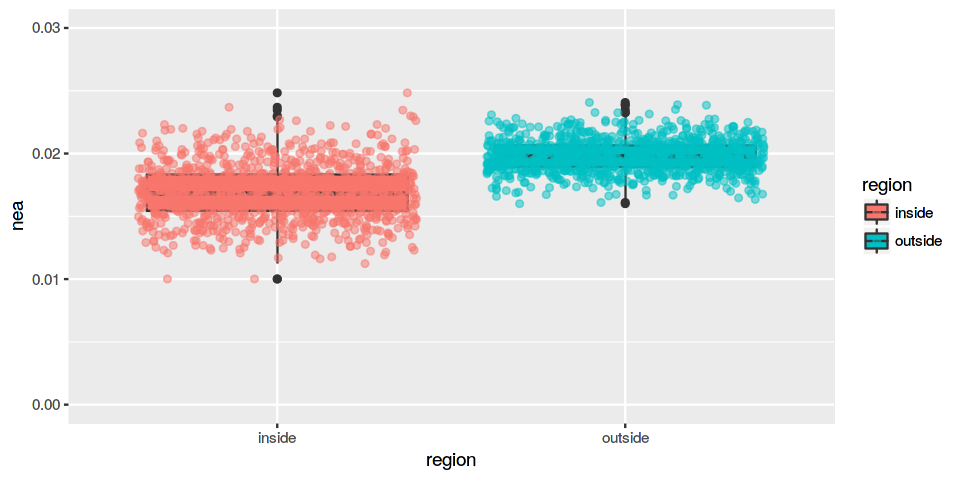

In [11]:
options(repr.plot.width = 8, repr.plot.height = 4)

gather(nea_prop, region, nea) %>%
ggplot(aes(region, nea, fill = region)) + geom_boxplot() + geom_jitter(aes(color = region), alpha = 1/2) +
ylim(0, 0.03)

## Nea ancestry vs distance to selected regions

In [81]:
n_bins <- 10

Load the table of coordinates (real and SLiM-based) of functional regions:

In [82]:
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))

In [83]:
trans_regions <- transpose_coordinates(regions, regions)

Load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions):

In [84]:
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

In [155]:
gens <- c(10, 20, 50, 100, seq(200, 1000, 200), seq(1200, 2200, 200))

In [156]:
bin_chrom_props <- mclapply(1:10, mc.cores = 10, function(rep) {
    
map_dfr(gens, function(gen) {

    vcf <- read_vcf(paste0("../data/simulations/delta_constant_exon_h_0.5_rep_", rep, "_gen_", gen, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% trans_regions]
    outside_markers <- trans_markers[! trans_markers %within% trans_regions]

    hap_ids <- colnames(mcols(markers)) %>% keep(~ str_detect(.x, "chr"))

    distance_hits <- distanceToNearest(outside_markers, trans_regions, ignore.strand = TRUE)
    qs <- quantile(mcols(distance_hits)$distance, probs = seq(0, 1, 1 / n_bins))

    nea_dist <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(distance = mcols(distance_hits)$distance,
               dist_bin = cut(distance, breaks = qs, labels = 1:n_bins, include.lowest = TRUE)) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, distance, dist_bin, starts_with("chr"))

})

}) %>% bind_rows

In [162]:
bin_props <- group_by(bin_chrom_props, dist_bin, gen) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -dist_bin, -gen) %>%
    ungroup %>% 
    mutate(dist_bin = factor(dist_bin))

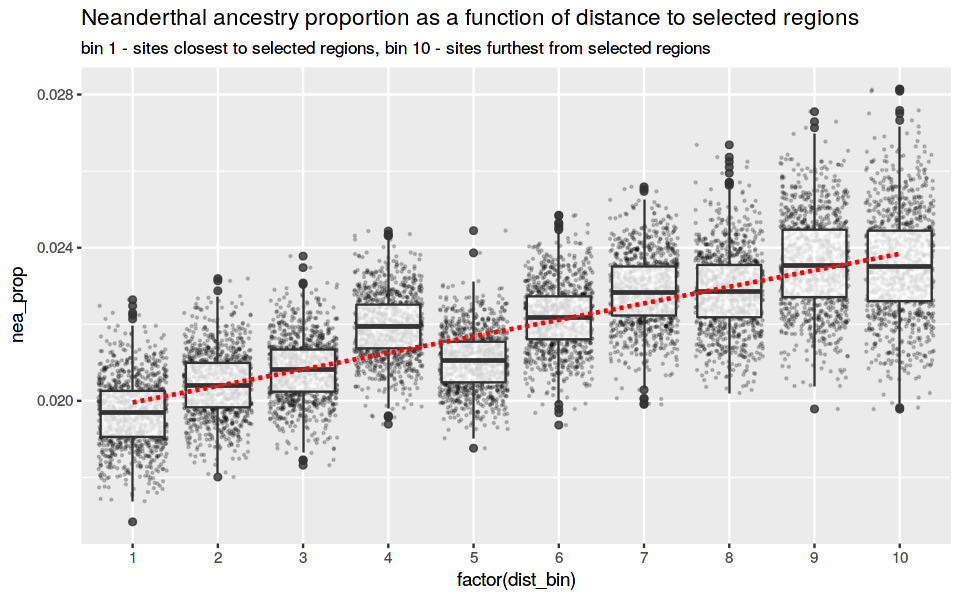

In [164]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>% filter(gen == 2200) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

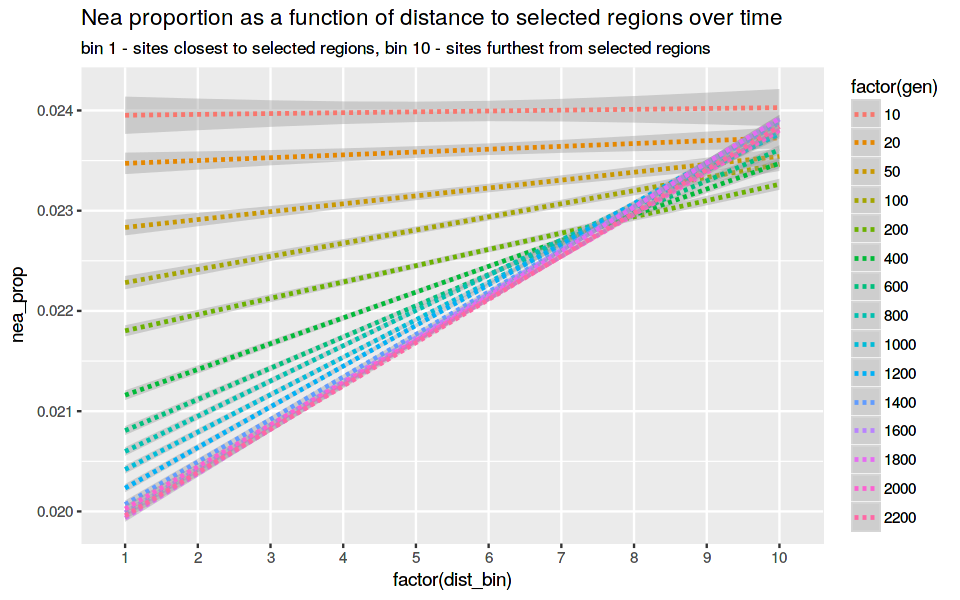

In [165]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>%
    ggplot(aes(factor(dist_bin), nea_prop, color = factor(gen), group = factor(gen))) +
        geom_smooth(method = "lm", linetype = 2) +
        ggtitle("Nea proportion as a function of distance to selected regions over time",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

In [166]:
saveRDS(bin_props, "../paper/rds/depletion_near_genes.rds")